In [1]:
# Stock Market Direction Prediction – SPY

# ==========================
# Imports & configuration
# ==========================

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import seaborn as sns

In [2]:
# ==========================
# Data collection
# ==========================

ticker = "SPY"

data = yf.download(ticker, start="1990-01-01")

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
1993-01-29,24.241398,24.258639,24.137950,24.258639,1003200
1993-02-01,24.413824,24.413824,24.258651,24.258651,480500
1993-02-02,24.465538,24.482779,24.344848,24.396572,201300
1993-02-03,24.724163,24.741404,24.482783,24.500025,529400
1993-02-04,24.827623,24.879348,24.534519,24.810382,531500


In [3]:
data = data["Close"]

In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data=data.squeeze()
type(data)

pandas.core.series.Series

In [6]:
# ==========================
# Data preparation
# ==========================

close=data
returns = close.pct_change()
returns.head()

Date
1993-01-29         NaN
1993-02-01    0.007113
1993-02-02    0.002118
1993-02-03    0.010571
1993-02-04    0.004185
Name: SPY, dtype: float64

In [7]:
# ==========================
# Target creation
# ==========================

target = (returns.shift(-1) > 0).astype(int)

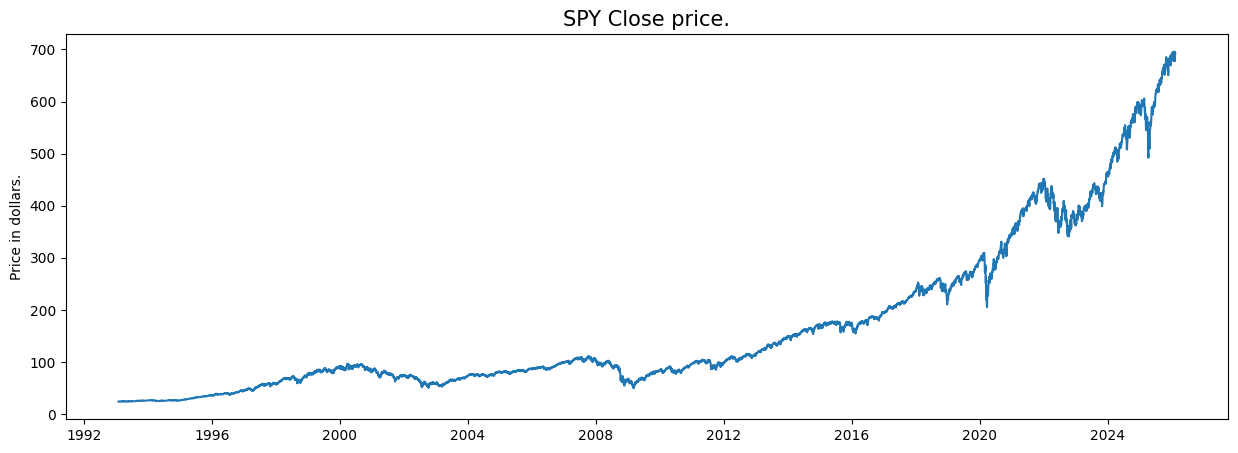

In [8]:
df = pd.DataFrame({
    "close": close,
    "return": returns,
    "target_up_tomorrow": target
})


plt.figure(figsize=(15,5))
plt.plot(df['close'])
plt.title('SPY Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [9]:
df= df.dropna()

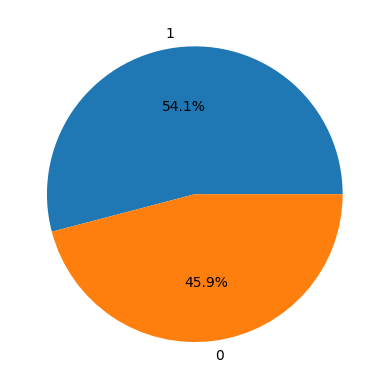

In [10]:
df["target_up_tomorrow"].value_counts(normalize=True)
plt.pie(df['target_up_tomorrow'].value_counts().values, 
        labels=[1, 0], autopct='%1.1f%%')
plt.show()

In [11]:
df.index.min(), df.index.max()

(Timestamp('1993-02-01 00:00:00'), Timestamp('2026-02-09 00:00:00'))

In [12]:
# ==========================
# Feature engineering
# ==========================

def add_return_features(df, horizons):
    df = df.copy()
    
    for h in horizons:
        df[f"return_lag_{h}"] = df["return"].shift(h)
        df[f"rolling_mean_{h}"] = df["return"].rolling(window=h).mean()
        df[f"rolling_std_{h}"] = df["return"].rolling(window=h).std()
        
    return df


df = add_return_features(df, horizons=[10, 50, 200])
df=df.dropna()
df.head()

,close,return,target_up_tomorrow,return_lag_10,rolling_mean_10,rolling_std_10,return_lag_50,rolling_mean_50,rolling_std_50,return_lag_200,rolling_mean_200,rolling_std_200
Date,,,,,,,,,,,,
1993-11-15,26.155901,-0.000671,1,0.002669,-0.000849,0.006499,0.000674,0.000218,0.005119,0.007113,0.000363,0.005999
1993-11-16,26.278793,0.004698,0,-0.000665,-0.000313,0.006733,-0.006739,0.000447,0.005057,0.002118,0.000375,0.006005
1993-11-17,26.138342,-0.005345,0,-0.012650,0.000418,0.005535,-0.003392,0.000407,0.005094,0.010571,0.000296,0.005975
1993-11-18,26.068136,-0.002686,0,-0.010789,0.001228,0.004126,0.002042,0.000313,0.005107,0.004185,0.000262,0.005972
1993-11-19,26.015469,-0.002020,0,0.004771,0.000549,0.004036,0.008831,0.000096,0.004966,-0.000695,0.000255,0.005974


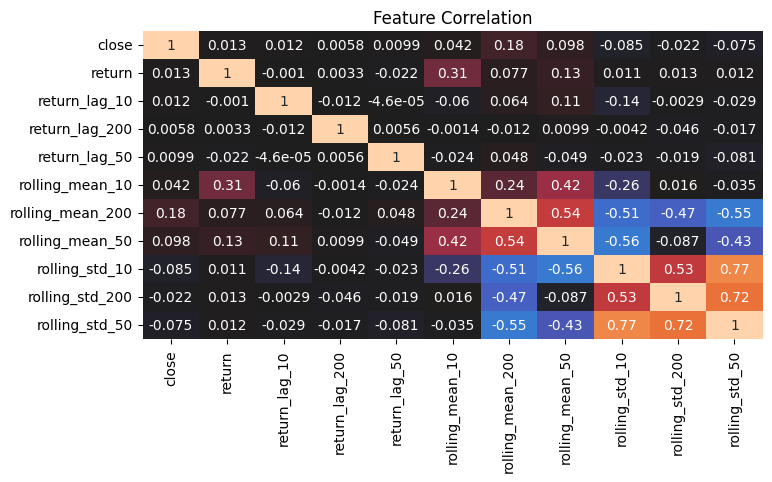

In [17]:
meta_cols = ["close", "return", "target_up_tomorrow"]

lag_cols = sorted([c for c in df.columns if c.startswith("return_lag")])
mean_cols = sorted([c for c in df.columns if c.startswith("rolling_mean")])
std_cols = sorted([c for c in df.columns if c.startswith("rolling_std")])

df = df[meta_cols + lag_cols + mean_cols + std_cols]



plt.figure(figsize=(8,4))
sns.heatmap(df.drop(columns=["target_up_tomorrow"]).corr(), 
             center=0, annot= True, cbar=False)
plt.title("Feature Correlation")
plt.show()

In [65]:
# ==========================
# Train-test split (time series)
# ==========================

y = df["target_up_tomorrow"]
X = df.drop(columns=["target_up_tomorrow", "close"])
X.shape, y.shape

((7913, 10), (7913,))

In [66]:
split_idx = int(len(df) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

In [67]:
X_train.index.min(), X_train.index.max()

(Timestamp('1994-08-31 00:00:00'), Timestamp('2019-10-21 00:00:00'))

In [68]:
X_test.index.min(), X_test.index.max()

(Timestamp('2019-10-22 00:00:00'), Timestamp('2026-02-09 00:00:00'))

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6330, 10), (1583, 10), (6330,), (1583,))

In [70]:
baseline = y_train.value_counts(normalize=True).max()
baseline

np.float64(0.5404423380726698)

In [71]:
# ==========================
# Baseline model – Logistic Regression
# ==========================

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [72]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

y_pred = log_model.predict(X_test_scaled)

accuracy_log_model= accuracy_score(y_test, y_pred)
classification_rep_log_model= classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy_log_model:.4f}")
print("\nClassification Report:\n", classification_rep_log_model)


Accuracy: 0.5527

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.10      0.17       704
           1       0.56      0.91      0.69       879

    accuracy                           0.55      1583
   macro avg       0.52      0.51      0.43      1583
weighted avg       0.53      0.55      0.46      1583



In [95]:
# ==========================
# Logistic Regression balanced
# ==========================


log_balanced = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

log_balanced.fit(X_train_scaled, y_train)

y_pred_balanced = log_balanced.predict(X_test_scaled)

accuracy_log_balanced = accuracy_score(y_test, y_pred_balanced)
classification_rep_log_balanced= classification_report(y_test, y_pred_balanced)
print(f"Accuracy: {accuracy_log_balanced:.4f}")
print("\nClassification Report:\n", classification_rep_log_balanced)

Accuracy: 0.5167

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.51      0.49       704
           1       0.57      0.52      0.54       879

    accuracy                           0.52      1583
   macro avg       0.52      0.52      0.51      1583
weighted avg       0.52      0.52      0.52      1583



In [91]:
# ==========================
# Random Forest model
# ==========================

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

accuracy_rf_model = accuracy_score(y_test, y_pred_rf)
classification_rep_rf_model= classification_report(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf_model:.4f}")
print("\nClassification Report:\n", classification_rep_rf_model)

Accuracy: 0.5546

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.13      0.20       704
           1       0.56      0.90      0.69       879

    accuracy                           0.55      1583
   macro avg       0.53      0.51      0.45      1583
weighted avg       0.53      0.55      0.47      1583



In [99]:
# ==========================
# Random Forest model balanced
# ==========================

rf_balanced = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    class_weight="balanced",
    random_state=42
)
rf_balanced.fit(X_train, y_train)
y_pred_rf_balanced = rf_balanced.predict(X_test)

accuracy_rf_balanced = accuracy_score(y_test, y_pred_rf_balanced)
classification_rep_rf_balanced= classification_report(y_test, y_pred_rf_balanced)
print(f"Accuracy: {accuracy_rf_balanced:.4f}")
print("\nClassification Report:\n", classification_rep_rf_balanced)

Accuracy: 0.5123

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.54      0.50       704
           1       0.57      0.49      0.53       879

    accuracy                           0.51      1583
   macro avg       0.51      0.51      0.51      1583
weighted avg       0.52      0.51      0.51      1583



In [106]:
# ==========================
# Gradient Boosting model
# ==========================

sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)


gb_model = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.01,
    max_iter=600,
    random_state=42
)

gb_model.fit(X_train, y_train, sample_weight=sample_weight)

y_pred_gb = gb_model.predict(X_test)

accuracy_gb_model = accuracy_score(y_test, y_pred_gb)
classification_rep_gb_model= classification_report(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb_model:.4f}")
print("\nClassification Report:\n", classification_rep_gb_model)

Accuracy: 0.5180

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.53      0.50       704
           1       0.57      0.51      0.54       879

    accuracy                           0.52      1583
   macro avg       0.52      0.52      0.52      1583
weighted avg       0.53      0.52      0.52      1583



In [121]:
# ==========================
# XGBoost model
# ==========================

ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb_model = accuracy_score(y_test, y_pred_xgb)
classification_rep_xgb_model= classification_report(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy_xgb_model:.4f}")
print("\nClassification Report:\n", classification_rep_xgb_model)

Accuracy: 0.5193

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.50      0.48       704
           1       0.57      0.53      0.55       879

    accuracy                           0.52      1583
   macro avg       0.52      0.52      0.52      1583
weighted avg       0.52      0.52      0.52      1583



In [126]:
# ==========================
# Model comparison
# ==========================

def extract_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    
    return {
        "accuracy": report["accuracy"],
        "recall_down - recall_up": abs(report["0"]["recall"]-report["1"]["recall"]),
        "recall_up":report["1"]["recall"],
        "recall_down": report["0"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"]
    }

results = []

results.append({
    "model": "Logistic Regression",
    **extract_metrics(y_test, y_pred_balanced)
})

results.append({
    "model": "Random Forest",
    **extract_metrics(y_test, y_pred_rf_balanced)
})

results.append({
    "model": "Gradient Boosting",
    **extract_metrics(y_test, y_pred_gb)
})

results.append({
    "model": "XGBoost",
    **extract_metrics(y_test, y_pred_xgb)
})

comparison_df = pd.DataFrame(results)

comparison_df.sort_values("accuracy", ascending=False).style.hide(axis="index")


model,accuracy,recall_down - recall_up,recall_up,recall_down,f1_macro
XGBoost,0.519267,0.034699,0.534699,0.500000,0.516581
Gradient Boosting,0.518004,0.023855,0.507395,0.531250,0.517005
Logistic Regression,0.516740,0.007125,0.519909,0.512784,0.514957
Random Forest,0.512318,0.046885,0.491468,0.538352,0.511771


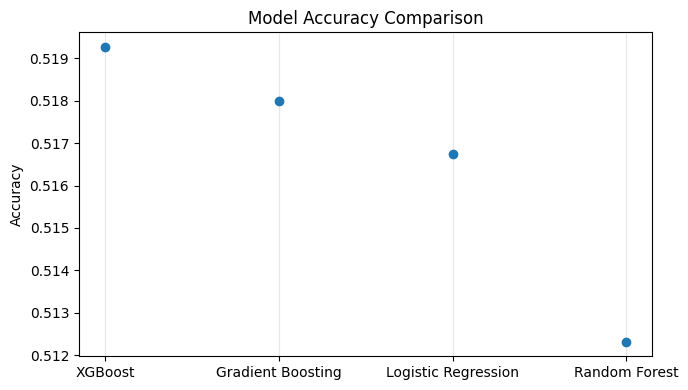

In [127]:
comparison_df=comparison_df.sort_values("accuracy", ascending=False)

plt.figure(figsize=(7,4))
plt.plot(comparison_df["model"], comparison_df["accuracy"], "o")

plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


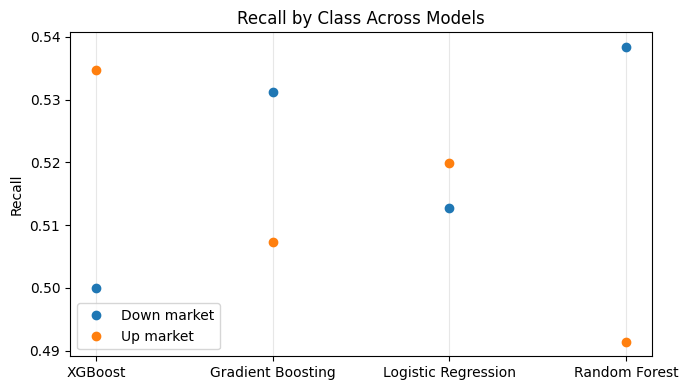

In [128]:
plt.figure(figsize=(7,4))

plt.plot(comparison_df["model"],comparison_df["recall_down"], "o", label="Down market")
plt.plot(comparison_df["model"],comparison_df["recall_up"], "o", label="Up market")

plt.ylabel("Recall")
plt.title("Recall by Class Across Models")
plt.grid(True, axis="x", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
